# CourseKata Student Performance Analysis

This notebook contains the analysis for predicting individual quiz performance from behavioral engagement in CourseKata.

## 1. Setup and Data Loading

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
sns.set_theme(style="whitegrid")  # or 'darkgrid', 'white', etc.
sns.set_palette('husl')

In [6]:
# Load the data
responses_df = pd.read_csv('coursekata-23-split80/data/filtered80_responses_2023.csv')
eoc_df = pd.read_csv('coursekata-23-split80/data/filtered80_eoc_2023.csv')

# Load codebooks
chapter_codebook = pd.read_csv('coursekata-23-split80/codebooks/codebook_chapter.csv')
page_codebook = pd.read_csv('coursekata-23-split80/codebooks/codebook_page.csv')
pageviews_codebook = pd.read_csv('coursekata-23-split80/codebooks/codebook_page_pageviews.csv')

## 2. Data Exploration

In [7]:
# Display basic information about the datasets
print("Responses DataFrame Info:")
print(responses_df.info())
print("\nEOC DataFrame Info:")
print(eoc_df.info())

Responses DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381091 entries, 0 to 381090
Data columns (total 49 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   institution_id               381091 non-null  object 
 1   class_id                     381091 non-null  object 
 2   course_name                  381091 non-null  object 
 3   release                      381091 non-null  object 
 4   book                         381091 non-null  object 
 5   student_id                   381091 non-null  object 
 6   lms_id                       381091 non-null  int64  
 7   item_id                      381091 non-null  object 
 8   item_type                    381091 non-null  object 
 9   chapter                      381091 non-null  object 
 10  page                         381091 non-null  object 
 11  response                     177437 non-null  object 
 12  prompt                       379

In [8]:
# Display summary statistics for EOC scores
print("Summary Statistics for EOC Scores:")
print(eoc_df.describe())

Summary Statistics for EOC Scores:
                1           2           3           4           5           6  \
count  560.000000  539.000000  529.000000  517.000000  533.000000  514.000000   
mean     0.855495    0.808615    0.777364    0.752116    0.745075    0.689235   
std      0.116025    0.143463    0.172970    0.194129    0.186246    0.197792   
min      0.230769    0.031250    0.064516    0.093750    0.000000    0.066667   
25%      0.769231    0.781250    0.709677    0.656250    0.656250    0.533333   
50%      0.846154    0.843750    0.806452    0.812500    0.781250    0.733333   
75%      0.923077    0.906250    0.870968    0.906250    0.875000    0.833333   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

                7           8           9  average_score  
count  525.000000  520.000000  515.000000     563.000000  
mean     0.624286    0.660150    0.610847       0.724166  
std      0.210366    0.212003    0.204993       0.147765  

In [11]:
responses_df.columns

Index(['institution_id', 'class_id', 'course_name', 'release', 'book',
       'student_id', 'lms_id', 'item_id', 'item_type', 'chapter', 'page',
       'response', 'prompt', 'points_possible', 'points_earned',
       'dt_submitted', 'completes_page', 'attempt', 'user_agent',
       'lrn_session_id', 'lrn_response_id', 'lrn_activity_reference',
       'lrn_question_reference', 'lrn_question_position', 'lrn_type',
       'lrn_dt_started', 'lrn_dt_saved', 'lrn_status', 'lrn_response_json',
       'lrn_option_0', 'lrn_option_1', 'lrn_option_2', 'lrn_option_3',
       'lrn_option_4', 'lrn_option_5', 'lrn_option_6', 'lrn_option_7',
       'lrn_option_8', 'lrn_option_9', 'lrn_option_10', 'lrn_option_11',
       'dt_submitted_processed', 'dt_submitted_processed_ms',
       'lrn_dt_started_processed', 'lrn_dt_started_processed_ms',
       'lrn_dt_saved_processed', 'lrn_dt_saved_processed_ms', 'chapter_num',
       'page_num'],
      dtype='object')

## 3. Data Preprocessing

In [12]:
# Convert timestamp to datetime
responses_df['dt_submitted_processed'] = pd.to_datetime(responses_df['dt_submitted_processed'])

# Create engagement metrics
def calculate_engagement_metrics(df):
    # Group by student and chapter
    engagement = df.groupby(['student_id', 'chapter_num']).agg({
        'item_id': 'count',  # Number of interactions
        'points_earned': ['sum', 'mean'],  # Total and average points
        'dt_submitted_processed': ['min', 'max']  # First and last interaction
    }).reset_index()
    
    # Calculate time spent (in minutes)
    engagement['time_spent'] = (engagement[('dt_submitted_processed', 'max')] - 
                               engagement[('dt_submitted_processed', 'min')]).dt.total_seconds() / 60
    
    return engagement

# Calculate engagement metrics
engagement_metrics = calculate_engagement_metrics(responses_df)

In [15]:
eoc_df.columns

Index(['book', 'release', 'institution_id', 'class_id', 'student_id', '1', '2',
       '3', '4', '5', '6', '7', '8', '9', 'average_score'],
      dtype='object')

## 4. Data Visualization

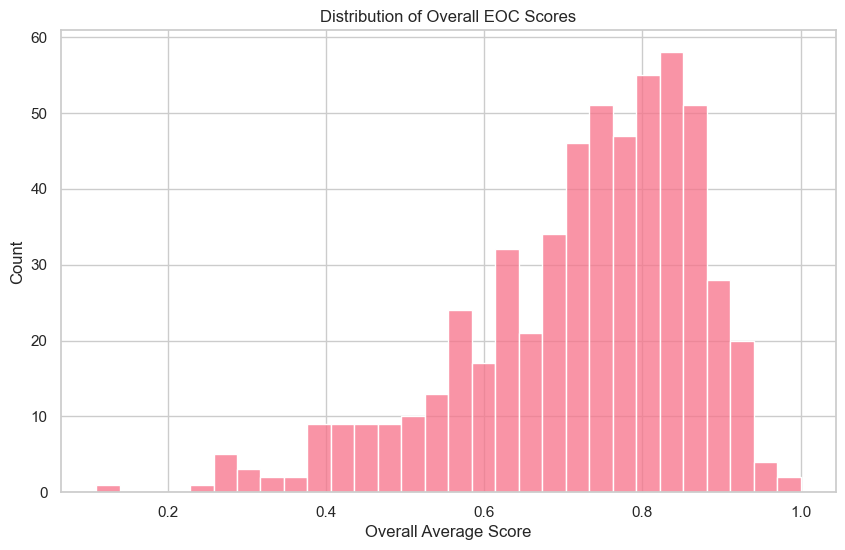

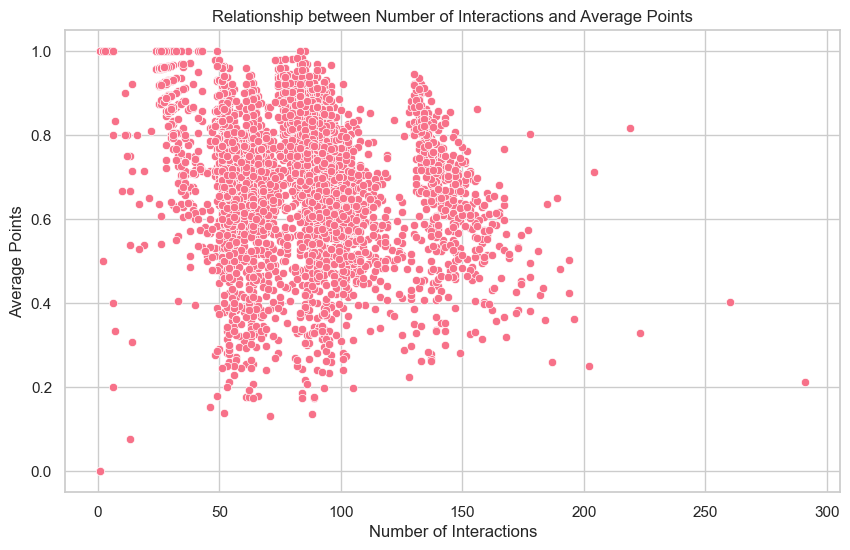

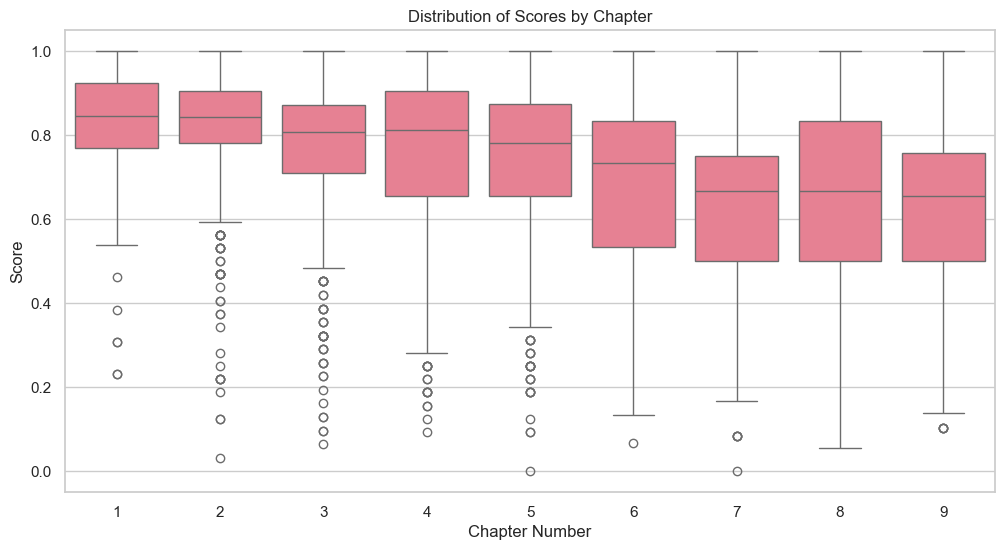

In [16]:
# Plot distribution of EOC scores
plt.figure(figsize=(10, 6))
sns.histplot(data=eoc_df, x='average_score', bins=30)
plt.title('Distribution of Overall EOC Scores')
plt.xlabel('Overall Average Score')
plt.ylabel('Count')
plt.show()

# Plot relationship between engagement and performance
plt.figure(figsize=(10, 6))
sns.scatterplot(data=engagement_metrics, 
                x=('item_id', 'count'), 
                y=('points_earned', 'mean'))
plt.title('Relationship between Number of Interactions and Average Points')
plt.xlabel('Number of Interactions')
plt.ylabel('Average Points')
plt.show()

# Additional visualization: Box plot of scores by chapter
plt.figure(figsize=(12, 6))
chapter_scores = pd.melt(eoc_df, 
                        id_vars=['student_id'],
                        value_vars=['1', '2', '3', '4', '5', '6', '7', '8', '9'],
                        var_name='Chapter',
                        value_name='Score')
sns.boxplot(data=chapter_scores, x='Chapter', y='Score')
plt.title('Distribution of Scores by Chapter')
plt.xlabel('Chapter Number')
plt.ylabel('Score')
plt.show()

## 5. Model Development

In [28]:
# Prepare data for modeling
def prepare_model_data(engagement_metrics, eoc_df):
    # Flatten the multi-level columns in engagement_metrics
    engagement_metrics.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col 
                                for col in engagement_metrics.columns]
    
    # Reshape eoc_df to long format for merging
    eoc_long = pd.melt(eoc_df, 
                      id_vars=['student_id'],
                      value_vars=['1', '2', '3', '4', '5', '6', '7', '8', '9'],
                      var_name='chapter_num',
                      value_name='score')
    
    # Convert chapter_num to integer for merging
    eoc_long['chapter_num'] = eoc_long['chapter_num'].astype(int)
    
    # Merge engagement metrics with EOC scores
    model_data = pd.merge(engagement_metrics, eoc_long, 
                         on=['student_id', 'chapter_num'], 
                         how='inner')
    
    # Select features for modeling
    features = ['item_id_count', 'points_earned_sum', 
                'points_earned_mean', 'time_spent']
    
    X = model_data[features]
    y = model_data['score']
    
    return X, y

# Prepare data
engagement_metrics.rename(columns={"student_id_": "student_id", "chapter_num_": "chapter_num"}, inplace=True)
X, y = prepare_model_data(engagement_metrics, eoc_df)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42)

KeyError: "['time_spent'] not in index"

In [26]:
engagement_metrics

,student_id_,chapter_num_,item_id_count,points_earned_sum,points_earned_mean,dt_submitted_processed_min,dt_submitted_processed_max,time_spent_
0,001824fb-a2fd-431d-aef6-7a1250d97a62,1,26,24.0,0.960000,2022-12-17 21:35:55+00:00,2022-12-17 23:00:10+00:00,84.250000
1,001824fb-a2fd-431d-aef6-7a1250d97a62,2,81,47.0,0.854545,2022-12-19 01:39:20+00:00,2023-01-13 22:17:25+00:00,37238.083333
2,001824fb-a2fd-431d-aef6-7a1250d97a62,3,92,50.0,0.684932,2023-01-16 01:16:33+00:00,2023-01-18 20:49:23+00:00,4052.833333
3,001824fb-a2fd-431d-aef6-7a1250d97a62,4,140,62.0,0.729412,2023-01-18 22:44:44+00:00,2023-01-21 01:56:55+00:00,3072.183333
4,001824fb-a2fd-431d-aef6-7a1250d97a62,5,52,21.0,0.677419,2023-01-22 02:14:18+00:00,2023-01-25 07:36:07+00:00,4641.816667
...,...,...,...,...,...,...,...,...
4836,ff6ec9fe-de1d-4b45-8136-59465d9c85ab,5,56,22.0,0.628571,2023-01-24 01:17:59+00:00,2023-01-25 03:53:53+00:00,1595.900000
4837,ff6ec9fe-de1d-4b45-8136-59465d9c85ab,6,104,42.0,0.512195,2023-01-29 22:03:00+00:00,2023-01-30 02:58:51+00:00,295.850000
4838,ff6ec9fe-de1d-4b45-8136-59465d9c85ab,7,57,26.0,0.472727,2023-02-01 03:14:17+00:00,2023-02-01 05:02:17+00:00,108.000000
4839,ff6ec9fe-de1d-4b45-8136-59465d9c85ab,8,68,36.0,0.620690,2023-02-08 02:51:15+00:00,2023-02-08 05:39:06+00:00,167.850000


In [ ]:
# Train and evaluate model
def train_and_evaluate_model(X_train, X_test, y_train, y_test):
    # Initialize and train model
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f'Mean Squared Error: {mse:.4f}')
    print(f'R-squared Score: {r2:.4f}')
    
    # Plot actual vs predicted values
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.title('Actual vs Predicted Scores')
    plt.xlabel('Actual Scores')
    plt.ylabel('Predicted Scores')
    plt.show()
    
    return model

# Train and evaluate the model
model = train_and_evaluate_model(X_train, X_test, y_train, y_test)

# Testing

In [42]:
import pandas as pd
df_20_test_features = pd.read_csv("filtered20_responses_2023.csv")
df_20_test_eoc = pd.read_csv("filtered20_eoc_2023.csv")

df_80_test_features = pd.read_csv("coursekata-23-split80/data/filtered80_responses_2023.csv")
df_80_test_eoc = pd.read_csv("filtered80_eoc_2023.csv")


/var/folders/k8/d10c5tmd1b5g9_7g8dbmpt600000gp/T/ipykernel_79120/2284610266.py:2: DtypeWarning: Columns (35,36) have mixed types. Specify dtype option on import or set low_memory=False.
  df_20_test_features = pd.read_csv("filtered20_responses_2023.csv")
/var/folders/k8/d10c5tmd1b5g9_7g8dbmpt600000gp/T/ipykernel_79120/2284610266.py:5: DtypeWarning: Columns (34,35,36) have mixed types. Specify dtype option on import or set low_memory=False.
  df_80_test_features = pd.read_csv("coursekata-23-split80/data/filtered80_responses_2023.csv")


In [61]:
c = "b7489f46-1d28-4c69-9901-3fb8bf9b85a6"
s = "0a1c6dbe-74fc-4984-9721-f301535753a4"
df_20_test_eoc[(df_20_test_eoc.class_id == c) & (df_20_test_eoc.student_id == s) & (df_20_test_eoc.chapter == 8)]

,id,book,release,institution_id,class_id,student_id,chapter,score
7,7,College / Advanced Statistics and Data Science...,v5.0,292cff87-3c74-4e94-8622-233afb0427dd,b7489f46-1d28-4c69-9901-3fb8bf9b85a6,0a1c6dbe-74fc-4984-9721-f301535753a4,8,NaN


In [58]:
df_20_test_features.groupby(['class_id', 'student_id']).size().reset_index(name='count').max()

class_id      cc1ffb2e-5555-4109-8ad8-2d49cb54ad10
student_id    fd2b27ac-109e-4512-9ab4-97953e1b168b
count                                          923
dtype: object

In [56]:
cols = ['class_id', 'student_id', 'chapter', 'page', 'item_id', 'item_type', 'points_earned', 'points_possible', 'prompt', 'lrn_response_json', 'attempt']
df_20_test_features[cols]#.loc[94276].lrn_response_json
# df_20_test_features.columns

,class_id,student_id,chapter,page,item_id,item_type,points_earned,points_possible,prompt,lrn_response_json,attempt
0,074123e7-cd90-4500-86fe-286aaa733bf5,85d5058c-53e9-49b1-8475-d3df2336b0ff,Chapter 1 - Welcome to Statistics: A Modeling ...,1.3 Doing Statistics with R,ch1-0,code,1.0,1.0,# type whatever you want\n# see... blah blah b...,NaN,1
1,074123e7-cd90-4500-86fe-286aaa733bf5,2bd80059-216d-4dc4-a1e3-73d786a2453e,Chapter 1 - Welcome to Statistics: A Modeling ...,1.3 Doing Statistics with R,ch1-0,code,1.0,1.0,# type whatever you want\n# see... blah blah b...,NaN,1
2,074123e7-cd90-4500-86fe-286aaa733bf5,ac7e3fd2-2ea7-4bdf-bf73-2309718dfea4,Chapter 1 - Welcome to Statistics: A Modeling ...,1.3 Doing Statistics with R,ch1-0,code,1.0,1.0,# type whatever you want\n# see... blah blah b...,NaN,1
3,074123e7-cd90-4500-86fe-286aaa733bf5,2c9559ea-5c7b-4c4b-a83c-6f0fdbc1cec5,Chapter 1 - Welcome to Statistics: A Modeling ...,1.3 Doing Statistics with R,ch1-0,code,1.0,1.0,# type whatever you want\n# see... blah blah b...,NaN,1
4,074123e7-cd90-4500-86fe-286aaa733bf5,c7bb202e-6a69-4a84-9814-e55e6bd6d54b,Chapter 1 - Welcome to Statistics: A Modeling ...,1.3 Doing Statistics with R,ch1-0,code,1.0,1.0,# type whatever you want\n# see... blah blah b...,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...
94276,b7489f46-1d28-4c69-9901-3fb8bf9b85a6,5ebbeac6-de5e-40ca-a390-29004251c918,Chapter 9 - Models with a Quantitative Explana...,9.11 Limitations to Keep in Mind,Embedded_0719_Ch8_Summary,learnosity,NaN,NaN,"In a paragraph, summarize the main idea(s) in ...","{""score"": null, ""response"": {""type"": ""string"",...",1
94277,b7489f46-1d28-4c69-9901-3fb8bf9b85a6,c57b5e43-11ba-4ec7-b911-2085b009e948,Chapter 9 - Models with a Quantitative Explana...,9.11 Limitations to Keep in Mind,Embedded_0719_Ch8_Summary,learnosity,NaN,NaN,"In a paragraph, summarize the main idea(s) in ...","{""score"": null, ""response"": {""type"": ""string"",...",1
94278,b7489f46-1d28-4c69-9901-3fb8bf9b85a6,5aa3b51f-7d60-4b8b-805e-9037f7e2f482,Chapter 9 - Models with a Quantitative Explana...,9.11 Limitations to Keep in Mind,Embedded_0719_Ch8_Summary,learnosity,NaN,NaN,"In a paragraph, summarize the main idea(s) in ...","{""score"": null, ""response"": {""type"": ""string"",...",1
94279,b7489f46-1d28-4c69-9901-3fb8bf9b85a6,52e06937-6b52-45f4-8ad9-974a9efc0df0,Chapter 9 - Models with a Quantitative Explana...,9.11 Limitations to Keep in Mind,Embedded_0719_Ch8_Summary,learnosity,NaN,NaN,"In a paragraph, summarize the main idea(s) in ...","{""score"": null, ""response"": {""type"": ""string"",...",1


In [53]:
df_20_test_features[df_20_test_features.lrn_response_json.isna()]

,institution_id,class_id,course_name,release,book,student_id,lms_id,item_id,item_type,chapter,...,lrn_option_10,lrn_option_11,dt_submitted_processed,dt_submitted_processed_ms,lrn_dt_started_processed,lrn_dt_started_processed_ms,lrn_dt_saved_processed,lrn_dt_saved_processed_ms,chapter_num,page_num
0,292cff87-3c74-4e94-8622-233afb0427dd,074123e7-cd90-4500-86fe-286aaa733bf5,UCLATALL/czi-stats-course,v5.0-exp1,College / Statistics and Data Science (ABC),85d5058c-53e9-49b1-8475-d3df2336b0ff,22798,ch1-0,code,Chapter 1 - Welcome to Statistics: A Modeling ...,...,NaN,NaN,2023-01-14T18:54:11Z,1.673722e+12,NaN,NaN,NaN,NaN,1,3
1,292cff87-3c74-4e94-8622-233afb0427dd,074123e7-cd90-4500-86fe-286aaa733bf5,UCLATALL/czi-stats-course,v5.0-exp1,College / Statistics and Data Science (ABC),2bd80059-216d-4dc4-a1e3-73d786a2453e,31833,ch1-0,code,Chapter 1 - Welcome to Statistics: A Modeling ...,...,NaN,NaN,2023-01-12T18:04:58Z,1.673547e+12,NaN,NaN,NaN,NaN,1,3
2,292cff87-3c74-4e94-8622-233afb0427dd,074123e7-cd90-4500-86fe-286aaa733bf5,UCLATALL/czi-stats-course,v5.0-exp1,College / Statistics and Data Science (ABC),ac7e3fd2-2ea7-4bdf-bf73-2309718dfea4,37668,ch1-0,code,Chapter 1 - Welcome to Statistics: A Modeling ...,...,NaN,NaN,2023-01-13T22:45:29Z,1.673650e+12,NaN,NaN,NaN,NaN,1,3
3,292cff87-3c74-4e94-8622-233afb0427dd,074123e7-cd90-4500-86fe-286aaa733bf5,UCLATALL/czi-stats-course,v5.0-exp1,College / Statistics and Data Science (ABC),2c9559ea-5c7b-4c4b-a83c-6f0fdbc1cec5,39196,ch1-0,code,Chapter 1 - Welcome to Statistics: A Modeling ...,...,NaN,NaN,2023-01-13T03:11:58Z,1.673580e+12,NaN,NaN,NaN,NaN,1,3
4,292cff87-3c74-4e94-8622-233afb0427dd,074123e7-cd90-4500-86fe-286aaa733bf5,UCLATALL/czi-stats-course,v5.0-exp1,College / Statistics and Data Science (ABC),c7bb202e-6a69-4a84-9814-e55e6bd6d54b,23649,ch1-0,code,Chapter 1 - Welcome to Statistics: A Modeling ...,...,NaN,NaN,2023-01-13T22:37:41Z,1.673649e+12,NaN,NaN,NaN,NaN,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94211,292cff87-3c74-4e94-8622-233afb0427dd,b7489f46-1d28-4c69-9901-3fb8bf9b85a6,UCLATALL/czi-stats-course,v5.0,College / Advanced Statistics and Data Science...,5113ed43-1e87-4dbb-a5c5-79107a25282f,46743,B5_Code_Fitting_02,code,Chapter 9 - Models with a Quantitative Explana...,...,NaN,NaN,2023-02-18T07:04:22Z,1.676704e+12,NaN,NaN,NaN,NaN,9,10
94212,292cff87-3c74-4e94-8622-233afb0427dd,b7489f46-1d28-4c69-9901-3fb8bf9b85a6,UCLATALL/czi-stats-course,v5.0,College / Advanced Statistics and Data Science...,e09abaf9-c6a9-47ce-8b3e-a6fc1ae60a62,95272,B5_Code_Fitting_02,code,Chapter 9 - Models with a Quantitative Explana...,...,NaN,NaN,2023-02-08T20:11:47Z,1.675887e+12,NaN,NaN,NaN,NaN,9,10
94213,292cff87-3c74-4e94-8622-233afb0427dd,b7489f46-1d28-4c69-9901-3fb8bf9b85a6,UCLATALL/czi-stats-course,v5.0,College / Advanced Statistics and Data Science...,e09abaf9-c6a9-47ce-8b3e-a6fc1ae60a62,95272,B5_Code_Fitting_02,code,Chapter 9 - Models with a Quantitative Explana...,...,NaN,NaN,2023-02-08T20:11:57Z,1.675887e+12,NaN,NaN,NaN,NaN,9,10
94214,292cff87-3c74-4e94-8622-233afb0427dd,b7489f46-1d28-4c69-9901-3fb8bf9b85a6,UCLATALL/czi-stats-course,v5.0,College / Advanced Statistics and Data Science...,5113ed43-1e87-4dbb-a5c5-79107a25282f,46743,B5_Code_Fitting_02,code,Chapter 9 - Models with a Quantitative Explana...,...,NaN,NaN,2023-02-18T07:05:57Z,1.676704e+12,NaN,NaN,NaN,NaN,9,10


In [40]:
df_20_test_eoc

,id,book,release,institution_id,class_id,student_id,chapter,score
0,0,College / Advanced Statistics and Data Science...,v5.0,292cff87-3c74-4e94-8622-233afb0427dd,b7489f46-1d28-4c69-9901-3fb8bf9b85a6,0a1c6dbe-74fc-4984-9721-f301535753a4,1,NaN
1,1,College / Advanced Statistics and Data Science...,v5.0,292cff87-3c74-4e94-8622-233afb0427dd,b7489f46-1d28-4c69-9901-3fb8bf9b85a6,0a1c6dbe-74fc-4984-9721-f301535753a4,2,NaN
2,2,College / Advanced Statistics and Data Science...,v5.0,292cff87-3c74-4e94-8622-233afb0427dd,b7489f46-1d28-4c69-9901-3fb8bf9b85a6,0a1c6dbe-74fc-4984-9721-f301535753a4,3,NaN
3,3,College / Advanced Statistics and Data Science...,v5.0,292cff87-3c74-4e94-8622-233afb0427dd,b7489f46-1d28-4c69-9901-3fb8bf9b85a6,0a1c6dbe-74fc-4984-9721-f301535753a4,4,NaN
4,4,College / Advanced Statistics and Data Science...,v5.0,292cff87-3c74-4e94-8622-233afb0427dd,b7489f46-1d28-4c69-9901-3fb8bf9b85a6,0a1c6dbe-74fc-4984-9721-f301535753a4,5,NaN
...,...,...,...,...,...,...,...,...
1178,1178,College / Statistics and Data Science (ABC),v5.2,292cff87-3c74-4e94-8622-233afb0427dd,cc1ffb2e-5555-4109-8ad8-2d49cb54ad10,fd2b27ac-109e-4512-9ab4-97953e1b168b,4,NaN
1179,1179,College / Statistics and Data Science (ABC),v5.2,292cff87-3c74-4e94-8622-233afb0427dd,cc1ffb2e-5555-4109-8ad8-2d49cb54ad10,fd2b27ac-109e-4512-9ab4-97953e1b168b,5,NaN
1180,1180,College / Statistics and Data Science (ABC),v5.2,292cff87-3c74-4e94-8622-233afb0427dd,cc1ffb2e-5555-4109-8ad8-2d49cb54ad10,fd2b27ac-109e-4512-9ab4-97953e1b168b,6,NaN
1181,1181,College / Statistics and Data Science (ABC),v5.2,292cff87-3c74-4e94-8622-233afb0427dd,cc1ffb2e-5555-4109-8ad8-2d49cb54ad10,fd2b27ac-109e-4512-9ab4-97953e1b168b,7,NaN


In [ ]:
import pandas as pd

# Define system prompts from our prompts.py file
from prompts import (
    system_prompt_past_performance_only,
    system_prompt_past_performance_plus_text,
    system_prompt_past_performance_plus_image,
    system_prompt_past_performance_plus_text_and_image
)

# Helper function to clean text
def clean_text(text):
    if pd.isna(text):
        return ""
    return str(text).strip().replace('\n', ' ').replace('\r', ' ')

def parse_inaccessible_images(image_url):
    pass

# Helper function to create a single exercise entry
def create_chapter_agg_prompt_code(df_chapter, user_prompt_end = USER_PROMPT_END, include_text=False, include_image=False):
    if include_text and include_image:
        system_prompt = system_prompt_past_performance_plus_text_and_image
    elif include_text:
        system_prompt = system_prompt_past_performance_plus_text
    elif include_image:
        system_prompt = system_prompt_past_performance_plus_image


    # USER_PROMPT = ""
        
    # messages = [
    #     {"role": "system", "content": system_prompt},
    #     {"role": "user", "content": USER_PROMPT}
    # ]
    # if image_urls:
    #     messages[1]['content'] = [USER_PROMPT]
    #     for image_url in image_urls:
    #         messages[1]['content'].append({
    #             "type": "image_url",
    #             "image_url": {
    #                 "url": image_url,
    #             },
    #         })

    user_prompt = ""
    for index, row in df_chapter.iterrows():
        base = f"\nChapter: {row['chapter']}\nPage Name: {row['page']}\nItem ID: {row['item_id']}\nItem Type: {row['item_type']}\nStudent earned {row['points_earned']} out of {row['points_possible']}."
        
        if include_text and include_image:
            if not pd.isna(row['page_context_text']):
                base += "\nPage Context:\n"
                text = clean_text(row.get('page_context_text', ''))
                if text:
                    base += text

            if not pd.isna(row['page_context_alt_text_and_images']):
                page_context_alt_text_and_images = eval(row.get('page_context_alt_text_and_images', ''))
                for image in page_context_alt_text_and_images:
                    if image[1].startswith('https://'):
                        base += f"\nImage Alt Text: {image[0]}"

        elif include_text :
            if not pd.isna(row['page_context_text']):
                base += "\nPage Context:\n"
                text = clean_text(row.get('page_context_text', ''))
                if text:
                    base += text
        
        elif include_image:
            if not pd.isna(row['page_context_images_only']):
                base += "\nSee images attached\n"

        user_prompt += base
    
    return user_prompt

# Group and create prompts
def generate_chapter_prompts(df):
    grouped = df.groupby(['class_id', 'student_id', 'book', 'chapter'])
    
    results = []

    for (class_id, student_id, book, chapter), group in grouped:
        # Sort by page for consistency
        group_sorted = group.sort_values(by='page')
        
        # Build each of the 4 prompt types
        prompt_perf_only = "\n".join(
            format_exercise(row, include_text=False, include_image=False) 
            for _, row in group_sorted.iterrows()
        )
        
        prompt_plus_text = "\n".join(
            format_exercise(row, include_text=True, include_image=False) 
            for _, row in group_sorted.iterrows()
        )
        
        prompt_plus_image = "\n".join(
            format_exercise(row, include_text=False, include_image=True) 
            for _, row in group_sorted.iterrows()
        )
        
        prompt_plus_text_and_image = "\n".join(
            format_exercise(row, include_text=True, include_image=True) 
            for _, row in group_sorted.iterrows()
        )
        
        results.append({
            'class_id': class_id,
            'student_id': student_id,
            'chapter': chapter,
            'Prompt_PastPerformanceOnly': prompt_perf_only,
            'Prompt_PastPerformancePlusText': prompt_plus_text,
            'Prompt_PastPerformancePlusImage': prompt_plus_image,
            'Prompt_PastPerformancePlusTextAndImage': prompt_plus_text_and_image,
        })
    
    return pd.DataFrame(results)

# Usage
df_chapter_prompts = generate_chapter_prompts(df_80_validate_features)

# Optional: inspect one row
print(df_chapter_prompts.iloc[0]['Prompt_PastPerformancePlusTextAndImage'])

In [ ]:
# async
# !pip install backoff
# !pip install openai
import asyncio
import backoff

from openai import OpenAI, AsyncOpenAI, RateLimitError
import dotenv
import json

dotenv.load_dotenv()
client = AsyncOpenAI()

@backoff.on_exception(backoff.expo, RateLimitError)
async def make_api_call_to_gpt(prompt, model="gpt-3.5-turbo"):
    messages = [{"role": "user", "content": prompt}]
    response = await client.chat.completions.create(
        model=model,
        messages=messages,
        temperature=0,
    )
    
    return response.choices[0].message.content

In [10]:
import pandas as pd
# get predictions for each prompt
# create empty df_test with 10 rows
df_test = pd.DataFrame(columns=['prediction_PastPerformanceOnly', 'prediction_PastPerformancePlusText', 'prediction_PastPerformancePlusImage', 'prediction_PastPerformancePlusTextAndImage'], index=range(10))
# df_test['prediction_PastPerformanceOnly'] = ""
# df_test['prediction_PastPerformancePlusText'] = ""
# df_test['prediction_PastPerformancePlusImage'] = ""
# df_test['prediction_PastPerformancePlusTextAndImage'] = ""

print("Each df has rows: ", len(df_test))
# print("Total API calls needed: ", len(df_20_test_features) * 4)
for i in range(len(df_test)):
    print(f"On API call: {i} out of {len(df_test)}")
    df_test.loc[i, 'prediction_PastPerformanceOnly'] = make_api_call_to_gpt("Hello")
    df_test.loc[i, 'prediction_PastPerformancePlusText'] = make_api_call_to_gpt("Hello")
    df_test.loc[i, 'prediction_PastPerformancePlusImage'] = make_api_call_to_gpt("Hello")
    df_test.loc[i, 'prediction_PastPerformancePlusTextAndImage'] = make_api_call_to_gpt("Hello")


Each df has rows:  10
On API call: 0 out of 40
On API call: 1 out of 40
On API call: 2 out of 40
On API call: 3 out of 40
On API call: 4 out of 40
On API call: 5 out of 40
On API call: 6 out of 40
On API call: 7 out of 40
On API call: 8 out of 40
On API call: 9 out of 40
